# help

In [12]:
from mesa import Agent, Model
from mesa.discrete_space import CellAgent, FixedAgent

# Analysis
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid

In [18]:
class RödBlodcell(FixedAgent):
    
    def __init__(self, model, point, infektionsrisk):
        # run the __init__ method of the parent class
        super().__init__(model)
        
        # additional initialization for the derived class
        self.point = 1 # point som visar att blodcellen "lever"
        self.alive = True # den lever
        self.infektionsrisk = 0.5 #varannan merozoite lyckas infektera blodcellen

    def step(self):
        if self.point <= 0: # om den mött på en merozoite så blir den infekterad och förlorar sin poäng
            self.alive = False # Nu död

In [19]:
class SickelCell(FixedAgent):
    
    def __init__(self, model, point, infektionsrisk):
        # run the __init__ method of the parent class
        super().__init__(model)
        
        # additional initialization for the derived class
        self.point = 1 # point som visar att blodcellen "lever"
        self.alive = True # den lever
        self.infektionsrisk = 0.5 #varannan merozoite lyckas infektera blodcellen
    
    def step(self):
        if self.point <= 0: # om den mött på en merozoite så blir den infekterad och förlorar sin poäng
            self.alive = False # Now dead

In [ ]:
class Merozoites(Agent):
    
    def __init__(self, model):
        # run the __init__ method of the parent class
        super().__init__(model)
    
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,  # current position
            moore=True,  # including step on the diagonal
            include_center=False,  # to remain at current position is not allowed
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)  

    def infektion(self):
        # detta är liknande moneywealth
        #cellmates = self.model.grid.get_cell_list_contents([self.pos])
        #if len(cellmates) > 1:
            #other = self.random.choice(cellmates)
            #other.point -= 1

        # liknande wolfsheep
        rödblodkropp = [obj for obj in self.cell.agents if isinstance(obj, Rödblodkropp)]
        if rödblodkropp: # om det finns en rödblodkropp i cellen
            rödblodkropp_att_infektera = self.random.choise(Rödblodkropp) # välj random rödblodkropp att infektera
            rödblodkropp_att_infektera.step() #utför då step för rödblodkropp
            

    def step(self):
        self.move()
        if self.point <= 0:
            self.alive = False # Now dead


In [4]:
class MoneyModel(Model):
    def __init__(self, N, width, height):
        # run the __init__ method of the parent class
        super().__init__()
        # additional initialization for the derived class
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.datacollector = DataCollector(
            model_reporters={
                "Gini coefficient": compute_gini  # function defined below
            },
            agent_reporters={
                "Agent wealth": "wealth",
                "Agent position": "pos",
            },  # agent attributes
        )

        # Create agents
        for unique_id in range(self.num_agents):
            agent = MoneyAgent(self)
            # self.schedule.add(agent)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("step")

In [5]:
def compute_gini(model):
    N = model.num_agents

    # collect wealth of agent into a list and sort it in increasing order
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)

    # calculate the Gini coefficient
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / sum(x)
    G = (N + 1 - 2 * B) / N

    return G

In [6]:
model = MoneyModel(50, 10, 10)

for i in range(100):
    model.step()

In [7]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

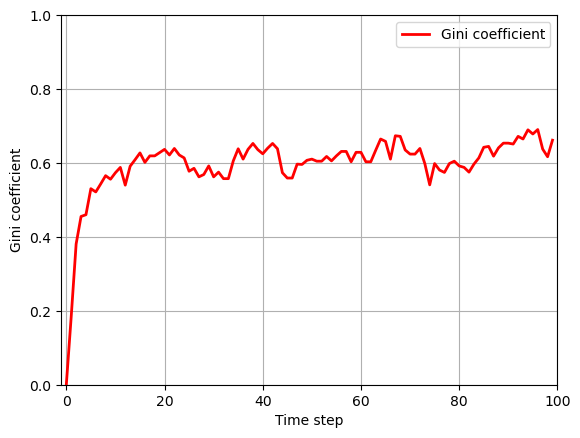

In [8]:
import matplotlib.pyplot as plt

model_df.plot(color="r", lw=2)

plt.ylabel("Gini coefficient")
plt.xlabel("Time step")
plt.grid("on")
plt.setp(plt.gca(), xlim=(-1, 100), ylim=(0, 1))

plt.show()